<h1 style="text-align:center">Fashion MNIST Classifier</h1>

## Import necessary Libraries

In [18]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Obtain datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.FashionMNIST('../datasets/',train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('../datasets/',train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)

100.0%

Extracting ../datasets/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../datasets/FashionMNIST\raw


111.0%

Extracting ../datasets/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../datasets/FashionMNIST\raw


100.0%

Extracting ../datasets/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../datasets/FashionMNIST\raw


159.1%..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ../datasets/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../datasets/FashionMNIST\raw
Processing...
Done!


torch.Size([64, 1, 28, 28])


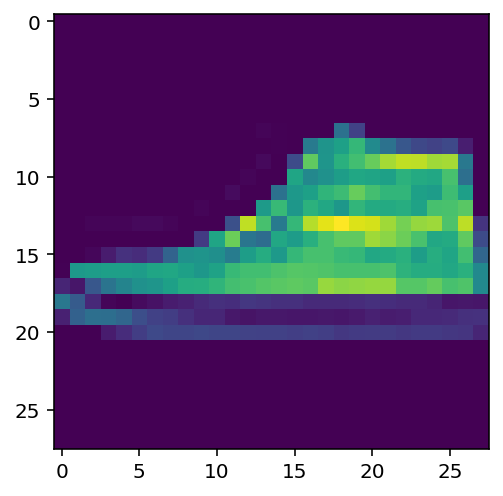

In [3]:
# Viewing an image from the datasets
image, label = next(iter(trainloader))
plt.imshow(image[0].view(image.shape[2],-1))
print(image.shape)

In [6]:
# number of classes
label.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Building the Network

In [42]:
# Network Architecture

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
        # adding a dropout for each layer with a drop probability of 20%
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flattening the images
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # the output layer doesn't require dropouts
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [43]:
# Creaing the network and defining Loss function and optimizer 
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

### Training and Validating the model

In [44]:
%%time
# Training the network
epochs = 30
train_losses, validation_losses = [], []

for i in range(epochs):
    running_loss = 0
    
    # loading images, 64 at a time.
    for images,labels in trainloader:
        # making a forward pass on the model and calculating loss
        net_output = model(images)
        loss = criterion(net_output, labels)
        
        # clearing the gradients and performing backpropagation
        optimizer.zero_grad()
        loss.backward()
        # optimising the model parameters based on the loss
        optimizer.step()
        
        # accumulates the losses over all the batches, ie. the entire training set
        running_loss += loss.item()
    else:
        validation_loss = 0
        accuracy = 0
        
        # keeping track of gradients and backpropagation isn't required
        # for validation and testing, hence we turn off gradients
        with torch.no_grad():
            # turns on evaluaton mode so that dropout is cut off
            # ie. dropout prob. is made 0%. We require the entire network during the evaluation and prediction stage
            model.eval()
            for images, labels in testloader:
                net_output = model(images)
                validation_loss += criterion(net_output, labels)
                
                # converting the log probabilities output form the network to probabilities
                probs = torch.exp(net_output)
                
                # identifying the top classes and probability vals.
                # we only need the class with the highest prob. vals. so 1 is specified
                # returns an array of most probable classes for each image.
                top_probs, top_class = probs.topk(1, dim=1)
                
                # to find all the matches between the preds. and the labels given
                # labels are a 1D vector and hence should be resized to the same shape as top_class
                equals = top_class == labels.view(*top_class.shape)
                
                # equals is a tensor of bool type - 0 or 1 corresponding to True or False for matches
                # this has to be converted into a float tensor to perform operations.
                accuracy = torch.mean(equals.type(torch.FloatTensor))
        
        # turning off eval. mode and allowing dropouts.
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        validation_losses.append(validation_loss/len(testloader))
        
        print("Epoch -> {}/{}".format(i+1, epochs),
              " Training Loss -> {:.3f} ".format(train_losses[-1]),
              " Validation Loss -> {:.3f} ".format(validation_losses[-1]),
              " Accuracy -> {:.3f} ".format(accuracy/len(testloader)))

Epoch -> 1/30  Training Loss -> 0.608   Validation Loss -> 0.463   Accuracy -> 0.005 
Epoch -> 2/30  Training Loss -> 0.485   Validation Loss -> 0.443   Accuracy -> 0.004 
Epoch -> 3/30  Training Loss -> 0.456   Validation Loss -> 0.414   Accuracy -> 0.005 
Epoch -> 4/30  Training Loss -> 0.436   Validation Loss -> 0.421   Accuracy -> 0.006 
Epoch -> 5/30  Training Loss -> 0.423   Validation Loss -> 0.403   Accuracy -> 0.006 
Epoch -> 6/30  Training Loss -> 0.415   Validation Loss -> 0.401   Accuracy -> 0.006 
Epoch -> 7/30  Training Loss -> 0.411   Validation Loss -> 0.396   Accuracy -> 0.006 
Epoch -> 8/30  Training Loss -> 0.399   Validation Loss -> 0.383   Accuracy -> 0.006 
Epoch -> 9/30  Training Loss -> 0.404   Validation Loss -> 0.399   Accuracy -> 0.006 
Epoch -> 10/30  Training Loss -> 0.388   Validation Loss -> 0.379   Accuracy -> 0.005 
Epoch -> 11/30  Training Loss -> 0.384   Validation Loss -> 0.386   Accuracy -> 0.006 
Epoch -> 12/30  Training Loss -> 0.388   Validation 

<h4>Plotting Training vs Validation Losses</h4>

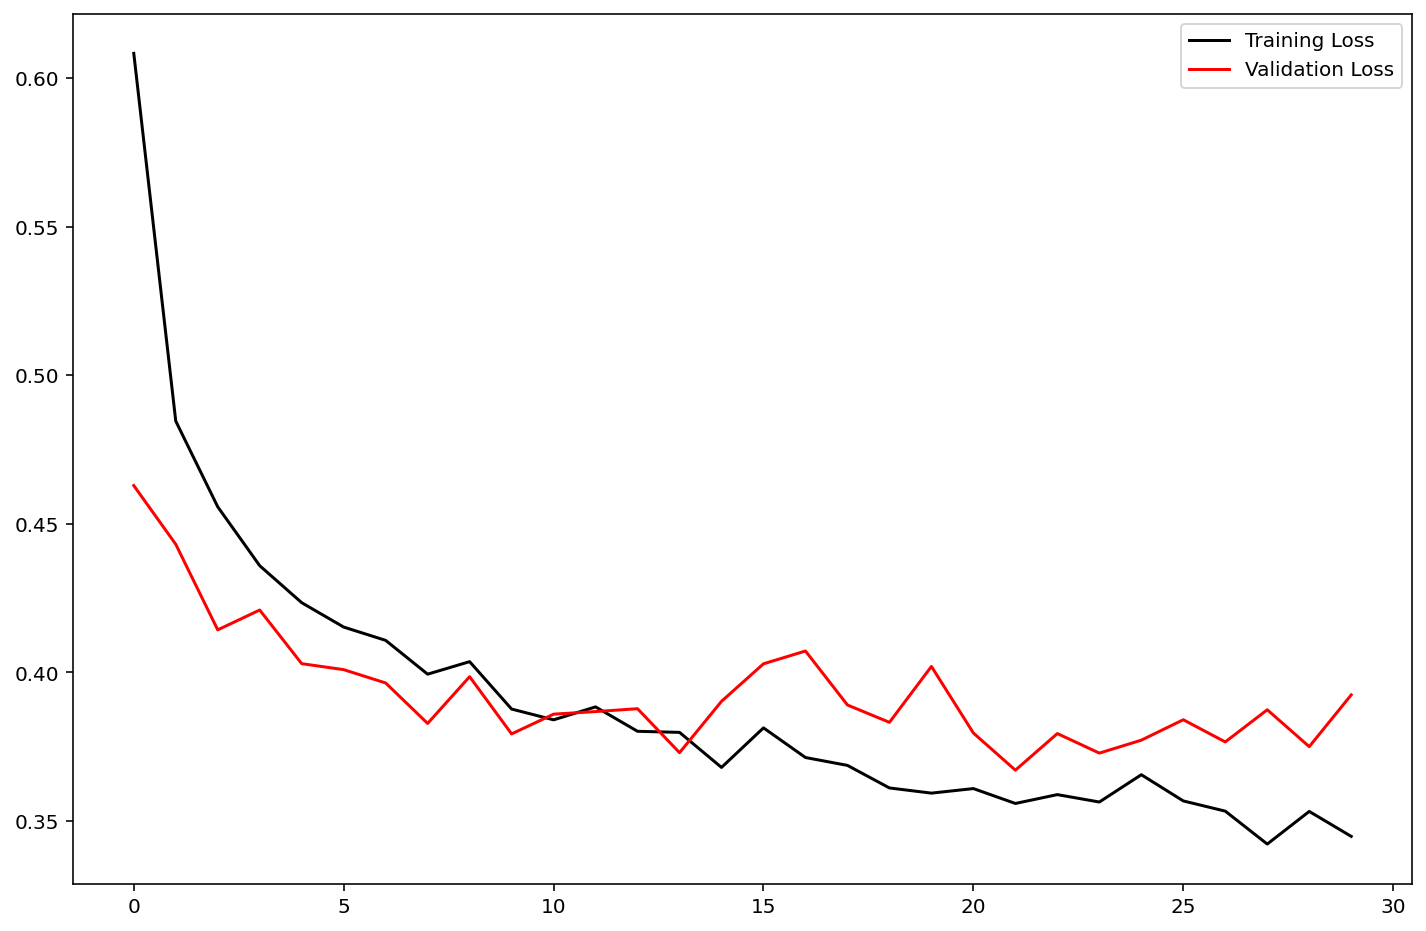

In [46]:
plt.figure(figsize=(12,8))
plt.plot(train_losses, label='Training Loss', color='black')
plt.plot(validation_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Loss Value',fontsize=15)
plt.tit
plt.legend()
plt.show()

## Testing the model

In [30]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,11), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

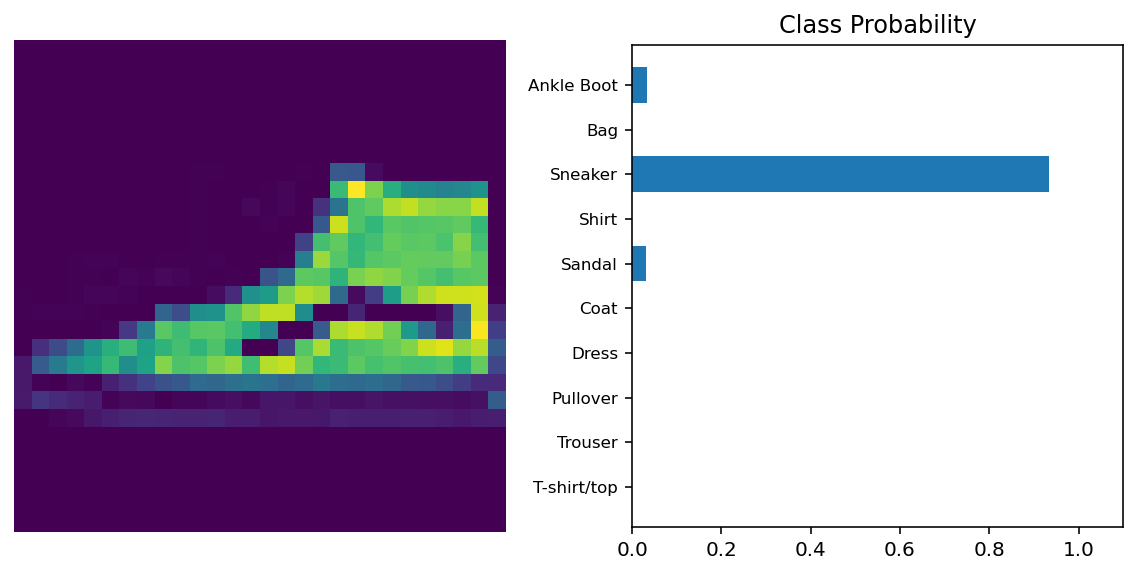

In [52]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()

# taking only a single image from the set
image = images[0]
# converting the 2D image into a 1D vector(i.e flattening)
image - image.resize_(1, 784)

with torch.no_grad():
    net_output = model.forward(image)

# calculating the probabiltiy distribution for the image classes
probs = torch.exp(net_output)

# plotting the image along with the probabilities
view_classify(image.resize_(1, 28, 28), probs, version='Fashion')